In [1]:
#Some code has been modeled based on CISCO's Joy. 

In [2]:
import numpy as np
import pymongo
#from sklearn import neural_network
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, log_loss, precision_score, f1_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import sys
import math
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import preprocessing
import matplotlib.pyplot as plt
from operator import add
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.mlab as mlab
import socket

In [3]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = client["flowdb"]
p_train_coll = mydb["p2"]
p_test_coll = mydb["testP"]
b_train_coll = mydb["b2"]
b_test_coll = mydb["testB"]
net_train_coll = mydb["Netflow"]

In [4]:
p_train = []
p_test = []
b_train = []
b_test = []
p_train_l = []
p_test_l = []
b_train_l = []
b_test_l = []


In [5]:
#these are for the individualPL 
numRows = 10
binSize = 150.0

b_byte_dist_h = [0] * 256
b_ipt_h = np.zeros((numRows, numRows))
p_byte_dist_h = [0] * 256
p_ipt_h = np.zeros((numRows, numRows))
b_pl = np.zeros((numRows,numRows))
p_pl = np.zeros((numRows,numRows))
b_ipts = []
p_ipts = []
b_pkt_size = []
p_pkt_size = []
b_flow_size = []
p_flow_size = []
b_num_pkts = []
p_num_pkts = []
b_flow_time = []
p_flow_time = []

In [6]:
#def adjust_threshold()

## methods to gather data from flow

In [7]:
def getBD(doc, flag):
    data = []
    if len(doc['packets']) == 0:
        return
    if doc['byte_dist'] != None and sum(doc['byte_dist']) > 0:
        tmp = map(lambda x: x / float(sum(doc['byte_dist'])), doc['byte_dist'])
        data.extend(tmp)
        if flag == 0:
            for i in range(len(tmp)):
                b_byte_dist_h[i] += tmp[i]
        elif flag == 1:
            for i in range(len(tmp)):
                p_byte_dist_h[i] += tmp[i]
    else:
        data.extend(np.zeros(256))
    return data

In [8]:
def getIndividualPL(flow, flag):
    transMat = np.zeros((numRows, numRows))
    if len(flow['packets']) == 0:
        return (list(transMat.flatten()))
    elif len(flow['packets']) == 1:
        curPacketSize = min(int(flow['packets'][0]['b'] / binSize), numRows - 1)
        transMat[curPacketSize, curPacketSize] = 1
        if (flag == 0):
            b_pl[curPacketSize, curPacketSize] += 1
        elif (flag == 1):
            p_pl[curPacketSize, curPacketSize] += 1
        
        return (list(transMat.flatten()))
        

    # get raw transition counts
    for i in range(1, len(flow['packets'])):
        prevPacketSize = min(int(flow['packets'][i - 1]['b'] / binSize), numRows - 1)
        if 'b' not in flow['packets'][i]:
            break
        curPacketSize = min(int(flow['packets'][i]['b'] / binSize), numRows - 1)
        transMat[prevPacketSize, curPacketSize] += 1
        
        if (flag == 0):
            b_pl[prevPacketSize, curPacketSize] += 1
        elif (flag == 1):
            p_pl[prevPacketSize, curPacketSize] += 1
        
    # get empirical transition probabilities
    for i in range(numRows):
        if float(np.sum(transMat[i:i + 1])) != 0:
            transMat[i:i + 1] = transMat[i:i + 1] / float(np.sum(transMat[i:i + 1]))

    return (list(transMat.flatten()))

In [9]:
def getIPT(flow, flag):
    #numRows = 10
    binSize = 50.0
    transMat = np.zeros((numRows, numRows))
    if len(flow['packets']) == 0:
        return (list(transMat.flatten()))
    elif len(flow['packets']) == 1:
        curIPT = min(int(flow['packets'][0]['ipt'] / float(binSize)), numRows - 1)
        transMat[curIPT, curIPT] = 1
        
        #for updating histograms/box charts
        if (flag == 0):
            b_ipt_h[curIPT, curIPT] += 1
        elif (flag == 1):
            p_ipt_h[curIPT, curIPT] += 1
        return (list(transMat.flatten()))
        

    # get raw transition counts
    for i in range(1, len(flow['packets'])):
        prevIPT = min(int(flow['packets'][i - 1]['ipt'] / float(binSize)), numRows - 1)
        curIPT = min(int(flow['packets'][i]['ipt'] / float(binSize)), numRows - 1)
        transMat[prevIPT, curIPT] += 1
        
        if (flag == 0):
            b_ipt_h[prevIPT, curIPT] += 1
        elif (flag == 1):
            p_ipt_h[prevIPT, curIPT] += 1

    # get empirical transition probabilities
    for i in range(numRows):
        if float(np.sum(transMat[i:i + 1])) != 0:
            transMat[i:i + 1] = transMat[i:i + 1] / float(np.sum(transMat[i:i + 1]))

    return (list(transMat.flatten()))

In [10]:
def getMD(flow, flag):
    tmp = []

    if flow['dp'] != None:
        tmp.append(float(flow['dp']))  # destination port
    else:
        tmp.append(0)  # ICMP/etc.
    if flow['sp'] != None:
        tmp.append(float(flow['sp']))  # source port
    else:
        tmp.append(0)  # ICMP/etc.
    if 'num_pkts_in' in flow:
        tmp.append(flow['num_pkts_in'])  # inbound packets
    else:
        tmp.append(0)
    if 'num_pkts_out' in flow:
        tmp.append(flow['num_pkts_out'])  # outbound packets
    else:
        tmp.append(0)
    if 'bytes_in' in flow:
        tmp.append(flow['bytes_in'])  # inbound bytes
    else:
        tmp.append(0)
    if 'bytes_out' in flow:
        tmp.append(flow['bytes_out'])  # outbound bytes
    else:
        tmp.append(0)
    # elapsed time of flow
    if flow['packets'] == []:
        tmp.append(0)
    else:
        time = 0
        for packet in flow['packets']:
            time += packet['ipt']
        tmp.append(time)
    return tmp

In [79]:
'''
use this to create the arrays. 
Collection- the collection to loop through,
data_set- the variable that the collection doc's are appended to
label_set- is the set that is used to train/test with the data set (pass in None if 
            its not all benign or all pirated), 
label- 1 for pirate, 0 for benign.
Chart- 1 to include in pirated graphs, 0 to include in benign graphs, anything else to
not include in either graphs
cond: used to specifiy any conditions to search for in the collection
'''
def set_up_array(collection, data_set, label_set=None, label=None, chart=-1, cond=None,
                bd=None, ipt=None, pl=None, ips=None, bytes=None, sp=None, dp=None):
    for doc in collection.find(cond):
        tmpd = []
        tmp = getMD(doc, chart)
        tmpb = getBD(doc, chart)
        if (bd == 1 and (tmpb is None or len(tmpb) != 256)):
            tmpb = np.zeros(256)
        elif (bd == 1):
            tmpb = preprocessing.scale(tmpb)
        tmpift = getIPT(doc, chart)

        #note: these 100's need to be changed if numRows is changed
        #if (tmpift is None or len(tmpift) != 100):
        #    continue

        tmpind_pl = getIndividualPL(doc, chart)
        #if (tmpind_pl is None or len(tmpind_pl) != 100):
        #    continue
        
        #get ipt's for graphs
        if(chart == 0):
            for pkt in doc['packets']:
                try:
                    b_ipts.append(pkt['ipt'])
                except Exception as e:
                    print e
                    pass
                try:
                    b_pkt_size.append(pkt['b'])
                except Exception as e:
                    print e
            #num bytes
            try:
                b_flow_size.append(doc['bytes_in'] + doc['bytes_out'])
            except:
                try:
                    b_flow_size.append(doc['bytes_in'])
                except:
                    try:
                        b_flow_size.append(doc['bytes_out'])
                    except Exception as e:
                        print e
                        pass
            
            
            #num pkts
            try:
                b_num_pkts.append(doc['num_pkts_in'] + doc['num_pkts_out'])
            except:
                try:
                    b_num_pkts.append(doc['num_pkts_in'])
                except:
                    try:
                        b_num_pkts.append(doc['num_pkts_out'])
                    except Exception as e:
                        print e
                        pass
            
                    
            #flow duration
            b_flow_time.append(tmp[6])
            
            
        elif(chart == 1):
            for pkt in doc['packets']:
                try:
                    p_ipts.append(pkt['ipt'])
                except Exception as e:
                    print e
                    pass
                try:
                    p_pkt_size.append(pkt['b'])
                except Exception as e:
                    print e
                    pass
            
            #num bytes
            try:
                p_flow_size.append(doc['bytes_in'] + doc['bytes_out'])
            except:
                try:
                    p_flow_size.append(doc['bytes_in'])
                except:
                    try:
                        p_flow_size.append(doc['bytes_out'])
                    except Exception as e:
                        print e
                        pass
            
            #num pkts
            try:
                p_num_pkts.append(doc['num_pkts_in'] + doc['num_pkts_out'])
            except:
                try:
                    p_num_pkts.append(doc['num_pkts_in'])
                except:
                    try:
                        p_num_pkts.append(doc['num_pkts_out'])
                    except Exception as e:
                        print e
                        pass
            #flow duration
            p_flow_time.append(tmp[6])
            
        if ips != None:
            ips.append((doc['sa'], doc['da']))
        if bytes != None:
            try:
                bytes.append(doc['bytes_in'] + doc['bytes_out'])
            except:
                try:
                    bytes.append(doc['bytes_in'])
                except:
                    try:
                        bytes.append(doc['bytes_out'])
                    except Exception as e:
                        print e
                        pass
        
        if sp != None:
            sp.append(doc['sp'])
        if dp != None:
            dp.append(doc['dp'])
        tmpd.extend(tmp)
        if bd == 1:
            tmpd.extend(tmpb)
        if ipt == 1:
            tmpd.extend(tmpift)
        if pl == 1:
            tmpd.extend(tmpind_pl)
        data_set.append(tmpd)
        try:
            label_set.append(label)
        except Exception as e:
            pass
            #print('No label set given')

## set up arrays using methods from above to be trained on

In [12]:
#collection, data_set, label_set=None, label=None, chart=-1, cond=None, bd=None, ipt=None, pl=None
set_up_array(p_train_coll, p_train, p_train_l, 1, 1)
set_up_array(p_test_coll, p_test, p_test_l, 1)


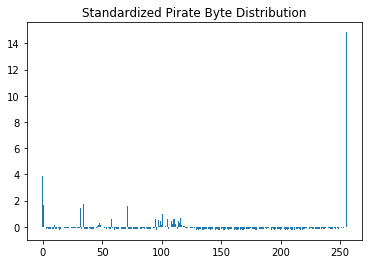

In [13]:
y_pos = np.arange(len(p_byte_dist_h))
x = preprocessing.scale(p_byte_dist_h)
plt.bar(y_pos, x)
plt.title("Standardized Pirate Byte Distribution")
plt.show()

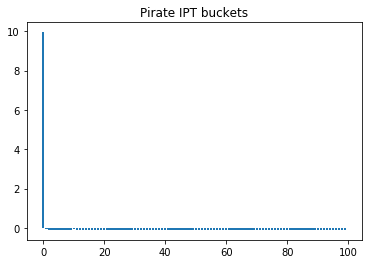

In [14]:
p_ipt_h = p_ipt_h.flatten()
y_pos = np.arange(len(p_ipt_h))
x = preprocessing.scale(p_ipt_h)
plt.bar(y_pos, x)
plt.title("Pirate IPT buckets")
plt.show()

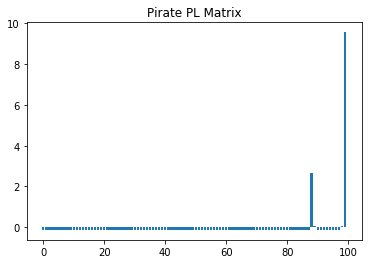

In [15]:
p_pl = p_pl.flatten()
y_pos = np.arange(len(p_pl))
x = preprocessing.scale(p_pl)
plt.bar(y_pos, x)
plt.title('Pirate PL Matrix')
plt.show()

In [16]:
set_up_array(b_train_coll, b_train, b_train_l, 0, 0)
set_up_array(b_test_coll, b_test, b_test_l, 0)


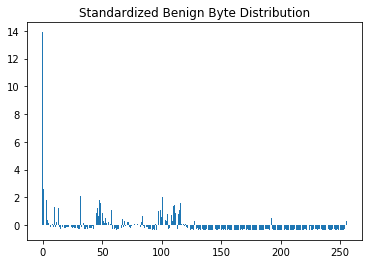

In [17]:
y_pos = np.arange(len(b_byte_dist_h))
x = preprocessing.scale(b_byte_dist_h)
plt.bar(y_pos, x)
plt.title("Standardized Benign Byte Distribution")
plt.show()

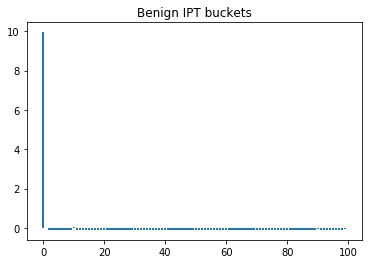

In [18]:
b_ipt_h = b_ipt_h.flatten()
y_pos = np.arange(len(b_ipt_h))
x = preprocessing.scale(b_ipt_h)
plt.bar(y_pos, x)
plt.title("Benign IPT buckets")
plt.show()

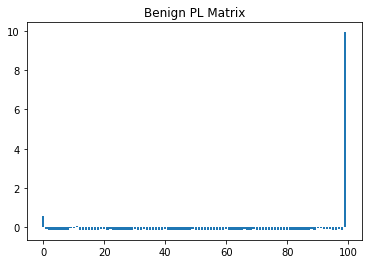

In [19]:
b_pl = b_pl.flatten()
y_pos = np.arange(len(b_pl))
x = preprocessing.scale(b_pl)
plt.bar(y_pos, x)
plt.title('Benign PL Matrix')
plt.show()

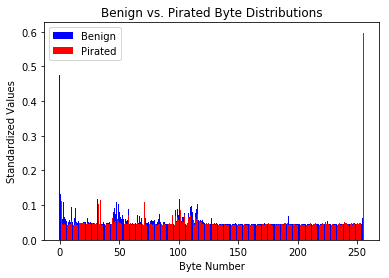

In [20]:
by_pos = np.arange(len(b_byte_dist_h))
b = preprocessing.normalize([b_byte_dist_h])
py_pos = np.arange(len(p_byte_dist_h))
p = preprocessing.normalize([p_byte_dist_h])

com = plt.subplot(111)
benign_box = com.bar(by_pos, b[0], color='b')
pirate_box = com.bar(py_pos+0.2, p[0], color='r')
com.legend((benign_box[0], pirate_box[0]), ('Benign', "Pirated"))
com.set_ylabel('Standardized Values')
com.set_xlabel('Byte Number')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Byte Distributions')
plt.show()


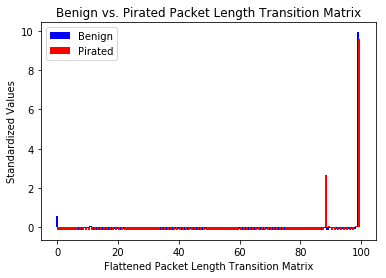

In [21]:
by_pos = np.arange(len(b_pl))
b = preprocessing.scale(b_pl)
py_pos = np.arange(len(p_pl))
p = preprocessing.scale(p_pl)

com = plt.subplot(111)
benign_box = com.bar(by_pos, b, color='b')
pirate_box = com.bar(py_pos+0.4, p, color='r')
com.legend((benign_box[0], pirate_box[0]), ('Benign', "Pirated"))
com.set_ylabel('Standardized Values')
com.set_xlabel('Flattened Packet Length Transition Matrix')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Packet Length Transition Matrix')
plt.show()


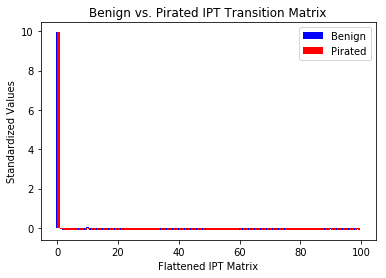

In [22]:
by_pos = np.arange(len(b_ipt_h))
b = preprocessing.scale(b_ipt_h)
py_pos = np.arange(len(p_ipt_h))
p = preprocessing.scale(p_ipt_h)

com = plt.subplot(111)
benign_box = com.bar(by_pos, b, color='b')
pirate_box = com.bar(py_pos+0.4, p, color='r')
com.legend((benign_box[0], pirate_box[0]), ('Benign', "Pirated"))
com.set_ylabel('Standardized Values')
com.set_xlabel('Flattened IPT Matrix')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated IPT Transition Matrix')
plt.show()

In [23]:
training_set = []
training_set.extend(b_train)
training_set.extend(p_train)
training_labels = []
training_labels.extend(b_train_l)
training_labels.extend(p_train_l)
training_set = np.array(training_set)
training_labels = np.array(training_labels)
b_train = np.array(b_train)
p_train = np.array(p_train)
b_train_l = np.array(b_train_l)
p_train_l = np.array(p_train_l)

In [24]:
test_set = []
test_labels = []
test_set.extend(b_test)
test_set.extend(p_test)
test_labels.extend(b_test_l)
test_labels.extend(p_test_l)
test_set = np.array(test_set)
test_labels = np.array(test_labels)
b_test = np.array(b_test)
p_test = np.array(p_test)
b_test_l = np.array(b_test_l)
p_test_l = np.array(p_test_l)

In [25]:
logreg = LogisticRegression()
logreg.fit(training_set, training_labels)
print(logreg.score(test_set, test_labels))
print(logreg.score(b_test, b_test_l))
print(logreg.score(p_test, p_test_l))

/home/thomasbelford/.local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.06016147429159305
0.9911196911196911
0.002920019941599601


In [26]:
print(logreg.score(training_set, training_labels))

0.5720922053371239


In [27]:
dt = DecisionTreeClassifier(criterion='gini')
dt.fit(training_set, training_labels)
print(dt.score(test_set, test_labels))
print(dt.score(b_test, b_test_l))
print(dt.score(p_test, p_test_l))

0.7356697157426252
0.9482625482625483
0.7225981055480379


In [28]:
'''n_test_coll = mydb["netflow_test"]
n_test = []
n_l = []
set_up_array(n_test_coll, n_test, n_l, 1, -1, {'$or':[{'da': '192.168.5.113'}, {'sa': '192.168.5.113'}]})'''


'n_test_coll = mydb["netflow_test"]\nn_test = []\nn_l = []\nset_up_array(n_test_coll, n_test, n_l, 1, -1, {\'$or\':[{\'da\': \'192.168.5.113\'}, {\'sa\': \'192.168.5.113\'}]})'

In [29]:
#print(dt.score(n_test, n_l))

In [30]:
#all benign test
ab_test_coll = mydb["bWeb"]
ab_test = []
ab_l = []
ab_s_ip = []
#ab_d_ip = []

set_up_array(ab_test_coll, ab_test, ab_l, 0, -1, ips=ab_s_ip)
'''
for doc in ab_test_coll.find():
    tmpd = []
    tmp = getMD(doc, -1)
    tmpb = getBD(doc, -1)
    #if (tmpb is None or len(tmpb) != 256):
    #    continue
    #tmpbd = preprocessing.scale(tmpb)
    #tmpift = getIPT(doc, -1)
    
    #note: these 100's need to be changed if numRows is changed
    #if (tmpift is None or len(tmpift) != 100):
    #    continue
        
    #tmpind_pl = getIndividualPL(doc, -1)
    #if (tmpind_pl is None or len(tmpind_pl) != 100):
    #    continue
    ab_s_ip.append((doc['sa'], doc['da']))
    
    tmpd.extend(tmp)
    #tmpd.extend(tmpb)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_pl)
    ab_test.append(tmpd)
    ab_l.append(0)
'''

"\nfor doc in ab_test_coll.find():\n    tmpd = []\n    tmp = getMD(doc, -1)\n    tmpb = getBD(doc, -1)\n    #if (tmpb is None or len(tmpb) != 256):\n    #    continue\n    #tmpbd = preprocessing.scale(tmpb)\n    #tmpift = getIPT(doc, -1)\n    \n    #note: these 100's need to be changed if numRows is changed\n    #if (tmpift is None or len(tmpift) != 100):\n    #    continue\n        \n    #tmpind_pl = getIndividualPL(doc, -1)\n    #if (tmpind_pl is None or len(tmpind_pl) != 100):\n    #    continue\n    ab_s_ip.append((doc['sa'], doc['da']))\n    \n    tmpd.extend(tmp)\n    #tmpd.extend(tmpb)\n    #tmpd.extend(tmpift)\n    #tmpd.extend(tmpind_pl)\n    ab_test.append(tmpd)\n    ab_l.append(0)\n"

In [31]:
print(dt.score(ab_test, ab_l))

0.7703703703703704


In [32]:
rf = RandomForestClassifier(bootstrap=False)
rf.fit(training_set, training_labels)

/home/thomasbelford/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
print(rf.score(test_set, test_labels))
print(rf.score(b_test, b_test_l))
print(rf.score(p_test, p_test_l))
#print(rf.score(n_test, n_l))
print(rf.score(ab_test, ab_l))

0.8707758370048979
0.9555984555984556
0.8655603826887923
0.762962962962963


In [34]:
probs = rf.predict_proba(ab_test)

In [35]:
for i in range(len(ab_test)):
    print('PB: {pb: <16} PP: {pp: <16} DA: {da: <16} SA: {sa: <16}'.format(
        pb=probs[i][0], pp=probs[i][1], da=ab_s_ip[i][1], sa=ab_s_ip[i][0]))

PB: 0.9              PP: 0.1              DA: 23.55.15.226     SA: 192.168.5.104   
PB: 1.0              PP: 0.0              DA: 10.0.2.15        SA: 172.26.1.12     
PB: 1.0              PP: 0.0              DA: 10.0.2.15        SA: 172.26.1.12     
PB: 1.0              PP: 0.0              DA: 10.0.2.15        SA: 172.26.1.12     
PB: 1.0              PP: 0.0              DA: 10.0.2.15        SA: 172.26.1.12     
PB: 0.4              PP: 0.6              DA: 10.0.2.15        SA: 172.26.1.12     
PB: 1.0              PP: 0.0              DA: 10.0.2.15        SA: 172.26.1.12     
PB: 1.0              PP: 0.0              DA: 10.0.2.15        SA: 172.26.1.12     
PB: 0.4              PP: 0.6              DA: 10.0.2.15        SA: 172.26.1.12     
PB: 0.5              PP: 0.5              DA: 52.84.128.7      SA: 10.0.2.15       
PB: 1.0              PP: 0.0              DA: 10.0.2.15        SA: 172.26.1.12     
PB: 1.0              PP: 0.0              DA: 10.0.2.15        SA: 172.26.1.

# Graphs

In [36]:

#df = pd.DataFrame(b_train)
#df_b_dist = pd.DataFrame(np.array(preprocessing.normalize([b_byte_dist_h])))
#df_p_dist = pd.DataFrame(np.array(preprocessing.scale(p_byte_dist_h)))
#df_b_ipt = pd.DataFrame(preprocessing.normalize([b_ipts])).T
df_b_ipt = pd.DataFrame(b_ipts)

#df_p_ipt = pd.DataFrame(preprocessing.normalize([p_ipts])).T
df_p_ipt = pd.DataFrame(p_ipts)
#df_b_pkt_size = pd.DataFrame(preprocessing.normalize([b_pkt_size])).T
df_p_pkt_size = pd.DataFrame(preprocessing.normalize([p_pkt_size])).T
df_b_pkt_size = pd.DataFrame(b_pkt_size)
#df_b_pkt_size = df_b_pkt_size[(np.abs(stats.zscore(df_b_pkt_size))<3).all(axis=1)]
#df_p_pkt_size = pd.DataFrame(p_pkt_size)
df_b_flow_size = pd.DataFrame(preprocessing.normalize([b_flow_size])).T
df_p_flow_size = pd.DataFrame(preprocessing.normalize([p_flow_size])).T
df_b_num_pkts = pd.DataFrame(preprocessing.normalize([b_num_pkts])).T
df_p_num_pkts = pd.DataFrame(preprocessing.normalize([p_num_pkts])).T
df_b_flow_time = pd.DataFrame(preprocessing.normalize([b_flow_time])).T
df_p_flow_time = pd.DataFrame(preprocessing.normalize([p_flow_time])).T

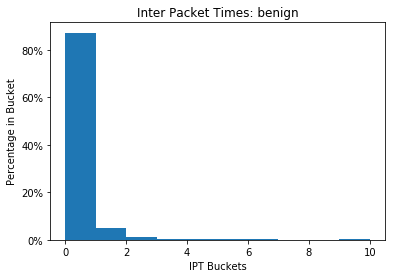

In [37]:
#df_b_ipt.plot(kind='hist')
#df_p_ipt.plot(kind='hist', color='r')
b_ipt2 = np.array([b_ipts])

b_ipt2 = b_ipt2[abs(b_ipt2 - np.mean(b_ipt2)) < 3 * np.std(b_ipt2)]
plt.hist(b_ipt2, weights=np.ones(len(b_ipt2))/len(b_ipt2), bins=10, range=(0,10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('IPT Buckets')
plt.ylabel('Percentage in Bucket')
plt.title('Inter Packet Times: benign')

plt.show()

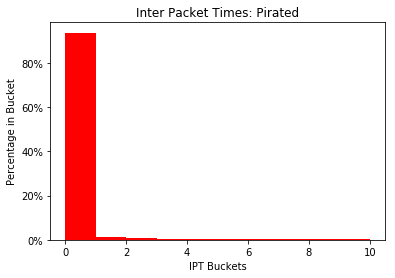

In [38]:
#df_b_pkt_size[(np.abs(stats.zscore(df_b_pkt_size)) < 3).all(axis=1)]
#df_p_pkt_size[(np.abs(stats.zscore(df_p_pkt_size)) < 3).all(axis=1)]
#df_p_pkt_size
#df_b_pkt_size.plot(kind='hist', bins=50, density=True)
#df_p_pkt_size.plot(kind='hist', color='r', bins=50, density=True)
#b_pkt_size_percent = df_p_pkt_size[0] / df_b_pkt_size[0].sum()
#df_b_pkt_size.plot(kind='hist', bins=100, xlim=(0,5000))
#sns.distplot(df_b_pkt_size, xlim=(0,5000))
p_ipt2 = np.array([p_ipts])

p_ipt2 = p_ipt2[abs(p_ipt2 - np.mean(p_ipt2)) < 3 * np.std(p_ipt2)]
plt.hist(p_ipt2, weights=np.ones(len(p_ipt2))/len(p_ipt2), bins=10, range=(0,10), color='r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('IPT Buckets')
plt.ylabel('Percentage in Bucket')
plt.title('Inter Packet Times: Pirated')

plt.show()

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


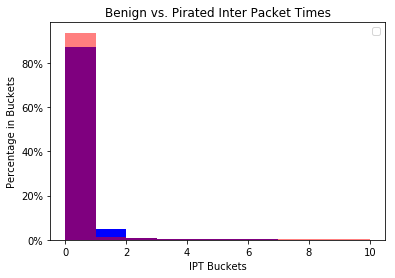

In [39]:
com = plt.subplot(111)
b_ipt_ = com.hist(b_ipt2, weights=np.ones(len(b_ipt2))/len(b_ipt2),
                    color='b', range=(0, 10), bins=10)
p_ipt_ = com.hist(p_ipt2, weights=np.ones(len(p_ipt2))/len(p_ipt2),
                    color='r', range=(0,10), bins=10, fc=(1, 0, 0, 0.5))
com.legend((b_ipt_[1], p_ipt_[1]), ('Benign', "Pirated"))
com.set_ylabel('Percentage in Buckets')
com.set_xlabel('IPT Buckets')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Inter Packet Times')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

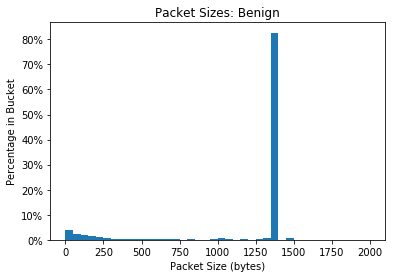

In [40]:
b2 = np.array(b_pkt_size)
#b2 = b2[abs(b2 - np.mean(b2)) < 3 * np.std(b2)]
plt.hist(b2, weights=np.ones(len(b2))/len(b2), range=(0,2000), bins=40)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('Packet Size (bytes)')
plt.ylabel('Percentage in Bucket')
plt.title('Packet Sizes: Benign')

plt.show()

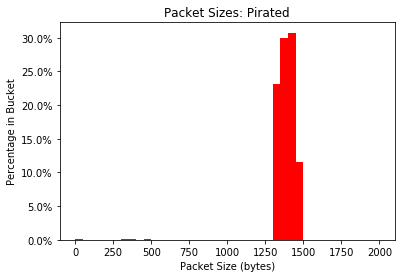

In [41]:
p2 = np.array(p_pkt_size)
#p2 = p2[abs(p2 - np.mean(p2)) < 3 * np.std(p2)]
plt.hist(p2, weights=np.ones(len(p2))/len(p2), color='r', range=(0,2000), bins=40)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('Packet Size (bytes)')
plt.ylabel('Percentage in Bucket')
plt.title('Packet Sizes: Pirated')

plt.show()

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000., 1050., 1100., 1150., 1200., 1250., 1300.,
       1350., 1400., 1450., 1500., 1550., 1600., 1650., 1700., 1750.,
       1800., 1850., 1900., 1950., 2000.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


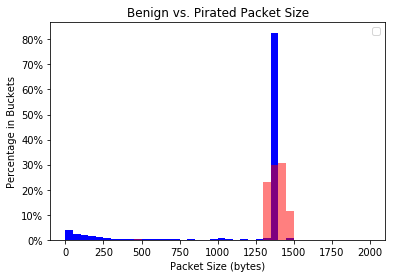

In [42]:
com = plt.subplot(111)
b_pkt_S = com.hist(b2, weights=np.ones(len(b2))/len(b2),
                    color='b', range=(0, 2000), bins=40)
p_pkt_S = com.hist(p2, weights=np.ones(len(p2))/len(p2),
                    color='r', range=(0,2000), bins=40, fc=(1, 0, 0, 0.5))
com.legend((b_pkt_S[1], p_pkt_S[1]), ('Benign', "Pirated"))
com.set_ylabel('Percentage in Buckets')
com.set_xlabel('Packet Size (bytes)')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Packet Size')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


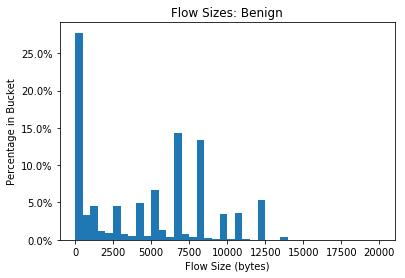

In [43]:
#df_b_flow_size.plot(kind='hist')
#df_p_flow_size.plot(kind='hist', color='r')
b_flows = np.array(b_flow_size)
b_flows = b_flows[abs(b_flows - np.mean(b_flows)) < 3 * np.std(b_flows)]
plt.hist(b_flows, weights=np.ones(len(b_flows))/len(b_flows), range=(0,20000), bins=40)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('Flow Size (bytes)')
plt.ylabel('Percentage in Bucket')
plt.title('Flow Sizes: Benign')

plt.show()

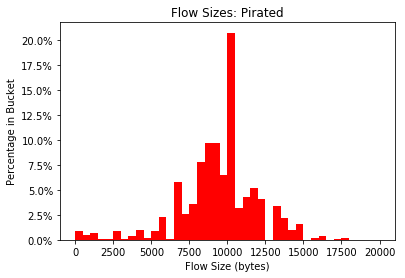

In [44]:
p_flows = np.array(p_flow_size)
p_flows = p_flows[abs(p_flows - np.mean(p_flows)) < 3 * np.std(p_flows)]
plt.hist(p_flows, weights=np.ones(len(p_flows))/len(p_flows), bins=40, range=(0,20000), color='r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('Flow Size (bytes)')
plt.ylabel('Percentage in Bucket')
plt.title('Flow Sizes: Pirated')

plt.show()

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([    0.,   500.,  1000.,  1500.,  2000.,  2500.,  3000.,  3500.,
        4000.,  4500.,  5000.,  5500.,  6000.,  6500.,  7000.,  7500.,
        8000.,  8500.,  9000.,  9500., 10000., 10500., 11000., 11500.,
       12000., 12500., 13000., 13500., 14000., 14500., 15000., 15500.,
       16000., 16500., 17000., 17500., 18000., 18500., 19000., 19500.,
       20000.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


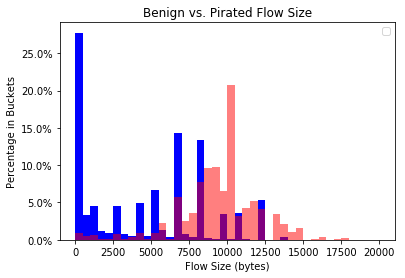

In [45]:
com = plt.subplot(111)
b_flow_s = com.hist(b_flows, weights=np.ones(len(b_flows))/len(b_flows),
                    color='b', range=(0, 20000), bins=40)
p_flow_s = com.hist(p_flows, weights=np.ones(len(p_flows))/len(p_flows),
                    color='r', range=(0,20000), bins=40, fc=(1, 0, 0, 0.5))
com.legend((b_flow_s[1], p_flow_s[1]), ('Benign', "Pirated"))
com.set_ylabel('Percentage in Buckets')
com.set_xlabel('Flow Size (bytes)')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Flow Size')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


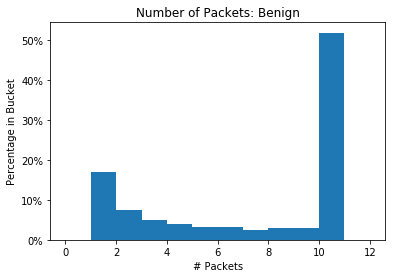

In [46]:
#df_b_num_pkts.plot(kind='hist')
#df_p_num_pkts.plot(kind='hist', color='r')
b_np = np.array(b_num_pkts)
b_np = b_np[abs(b_np - np.mean(b_np)) < 3 * np.std(b_np)]
plt.hist(b_np, weights=np.ones(len(b_np))/len(b_np), range=(0,12), bins=12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('# Packets')
plt.ylabel('Percentage in Bucket')
plt.title('Number of Packets: Benign')

plt.show()

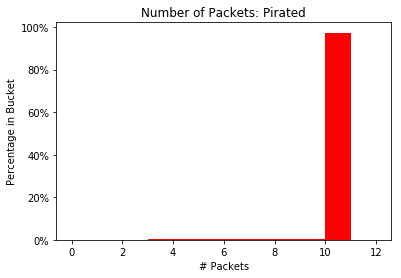

In [47]:
p_np = np.array(p_num_pkts)
p_np = p_np[abs(p_np - np.mean(p_np)) < 3 * np.std(p_np)]
plt.hist(p_np, weights=np.ones(len(p_np))/len(p_np), color='r', bins=12, range=(0,12))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('# Packets')
plt.ylabel('Percentage in Bucket')
plt.title('Number of Packets: Pirated')

plt.show()

/home/thomasbelford/.local/lib/python2.7/site-packages/matplotlib/legend.py:937: UserWarning: Legend does not support array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]) instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


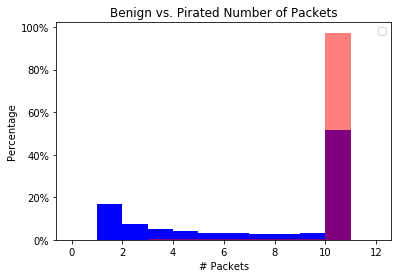

In [48]:
com = plt.subplot(111)
b_np_ = com.hist(b_np, weights=np.ones(len(b_np))/len(b_np),
                    color='b', range=(0, 12), bins=12)
p_np_ = com.hist(p_np, weights=np.ones(len(p_np))/len(p_np),
                    color='r', range=(0,12), bins=12, fc=(1, 0, 0, 0.5))
com.legend((b_np_[1], p_np_[1]), ('Benign', "Pirated"))
com.set_ylabel('Percentage')
com.set_xlabel('# Packets')
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Pirated Number of Packets')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

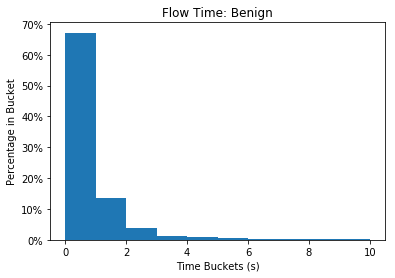

In [49]:
b_ft = np.array(b_flow_time)
b_ft = b_ft[abs(b_ft - np.mean(b_ft)) < 3 * np.std(b_ft)]

plt.hist(b_ft, weights=np.ones(len(b_ft))/len(b_ft), bins=10, range=(0, 10))


plt.xlabel('Time Buckets (s)')
plt.ylabel('Percentage in Bucket')
plt.title('Flow Time: Benign')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

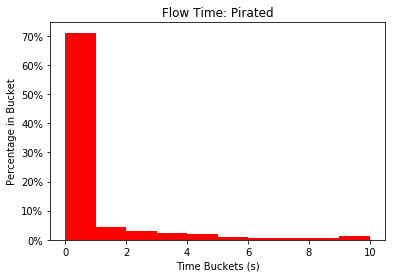

In [50]:
#df_b_flow_time.plot(kind='hist')
#df_p_flow_time.plot(kind='hist', color='r')
p_ft = np.array(p_flow_time)
p_ft = p_ft[abs(p_ft - np.mean(p_ft)) < 3 * np.std(p_ft)]
plt.hist(p_ft, weights=np.ones(len(p_ft))/len(p_ft), color='r', bins=10, range=(0, 10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlabel('Time Buckets (s)')
plt.ylabel('Percentage in Bucket')
plt.title('Flow Time: Pirated')

plt.show()

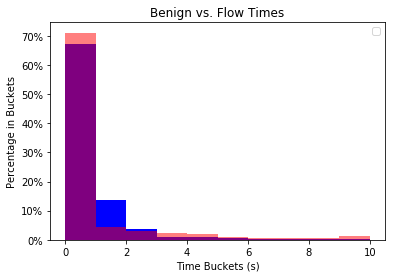

In [51]:
com = plt.subplot(111)
b_ft_ = com.hist(b_ft, weights=np.ones(len(b_ft))/len(b_ft),
                    color='b', range=(0, 10), bins=10)
b_kde_ft = stats.gaussian_kde(b_ft.T)

p_ft_ = com.hist(p_ft, weights=np.ones(len(p_ft))/len(p_ft),
                    color='r', range=(0,10), bins=10, fc=(1, 0, 0, 0.5))
p_kde_ft = stats.gaussian_kde(p_ft)
com.legend((b_ft_[1], p_ft_[1]), ('Benign', "Pirated"))
com.set_ylabel('Percentage in Buckets')
com.set_xlabel('Time Buckets (s)')
print (b_kde_ft)
#com.title('Benign vs. Pirated Byte Distributions')
plt.title('Benign vs. Flow Times')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.plot(com, b_kde_ft, p_kde_ft)
plt.show()

[1.06400e+03 1.06500e+03 2.30000e+01 ... 8.36000e+02 1.70089e+05
 0.00000e+00]


/home/thomasbelford/.local/lib/python2.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # Remove the CWD from sys.path while we load stuff.


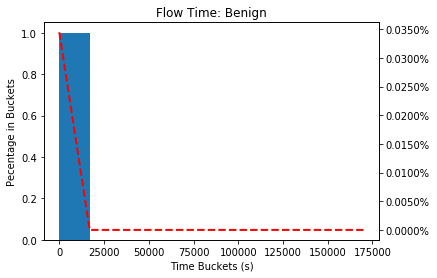

In [52]:
b_ft = np.array(b_flow_time)
b_ft = b_ft.astype(float)
b_ft = b_ft[abs(b_ft - np.mean(b_ft)) < 3 * np.std(b_ft)]
plt2, ax = plt.subplots()
print b_ft
n, bins, patches = ax.hist(b_ft, weights=np.ones(len(b_ft))/len(b_ft), )#bins=10, range=(0, 10), density=1)
ax.set_xlabel('Time Buckets (s)')
ax.set_ylabel('Pecentage in Buckets')
(mu, sigma) = stats.norm.fit(b_ft)
y = mlab.normpdf(bins, mu, sigma)

ax2 = ax.twinx()
l = ax2.plot(bins, y , 'r--', linewidth=2)
#b_ft_kde = stats.gaussian_kde(b_ft)
#b_ft_kde.covariance_factor = lambda : .25
#b_ft_kde._compute_covariance()
#ax2.set_ylabel('KDE')
#m = b_ft.mean()
#stdb = b_ft.std()
#y = ((1/(np.sqrt(2 * np.pi) * stdb))*np.exp(-0.5 * (1 / stdb * (bins - m))**2))
#x = np.linspace(0,10,1000)
#ax2.plot(x, b_ft_kde(x))
#print bins
#print y
#ax2.plot(bins, y, '--')

#plt.xlabel('Time Buckets (s)')
#plt.ylabel('Percentage in Bucket')
plt.title('Flow Time: Benign')
plt2.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

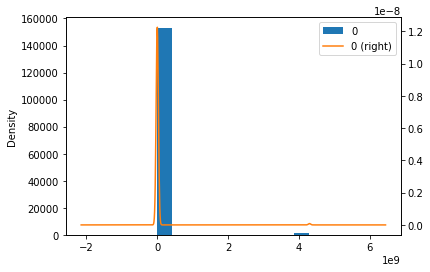

In [53]:
ax = df_b_ipt.plot(kind='hist')
df_b_ipt.plot(kind='kde', ax=ax, secondary_y=True)

In [54]:
metrics = [accuracy_score, precision_score, f1_score, log_loss]

In [55]:
def score_clf(clf, y_true, t_set):
    results = []
    #results.append(accuracy_score(y_true, y_pred))
    #results.append(precision_score(y_true, y_pred))
    y_pred = clf.predict(t_set)
    for metric in metrics:
        results.append(metric(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    #True Pos Rate = TP/FN+TP
    results.append(float(cm[0][0])/(cm[1][0] + cm[0][0]))
    #False Pos Rate = FP/FP+TN
    results.append(float(cm[0][1])/(cm[0][1]+cm[1][1]))
 
    return results

# Scoring

In [56]:
#boosterRF = AdaBoostClassifier(RandomForestClassifier())
#boosterRF.fit(training_set, training_labels)

#res.append(score_clf(log_reg, test_labels, test_set))
#res.append(score_clf(d_tree, test_labels, test_set))
#res.append(score_clf(rand_forest, test_labels, test_set))
#res.append(score_clf(dt_boost, test_labels, test_set))
#res.append(score_clf(boosterRF, test_labels, test_set))

In [57]:
log_reg = LogisticRegression()
log_reg.fit(training_set, training_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [58]:
d_tree = DecisionTreeClassifier()
d_tree.fit(training_set, training_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [59]:
rand_forest = rf #RandomForestClassifier()
#rand_forest.fit(training_set, training_labels)

In [60]:
#dt_boost = AdaBoostClassifier(DecisionTreeClassifier())
#dt_boost.fit(training_set, training_labels)

In [61]:
res=[]
clfs = [log_reg, d_tree, rand_forest] #dt_boost]#, boosterRF]
for clf in clfs:
    res.append(score_clf(clf, test_labels, test_set))
clf_names = ['LR:','DT:', 'RF:']#, 'BoostDT:']#, 'BoostRF:']

In [62]:

'''for i in range(len(res)):
    print ('%s Accuracy: %f Precision: %f F1: %f log_loss: %f' %  
          (clf_names[i], res[i][0], res[i][1], res[i][2], res[i][3]))
    print (' TruePos Rate: %f FalsePos Rate: %f' % (res[i][4], res[i][5]))'''

"for i in range(len(res)):\n    print ('%s Accuracy: %f Precision: %f F1: %f log_loss: %f' %  \n          (clf_names[i], res[i][0], res[i][1], res[i][2], res[i][3]))\n    print (' TruePos Rate: %f FalsePos Rate: %f' % (res[i][4], res[i][5]))"

In [63]:
score_df = pd.DataFrame(res)
score_df.columns = ['Accuracy', 'Precision', 'F1', 'Log_Loss', 'TruePosRate', 'FalsePosRate']
score_df.index = clf_names

In [64]:
score_df

,Accuracy,Precision,F1,Log_Loss,TruePosRate,FalsePosRate
LR:,0.060161,0.842466,0.00582,32.460873,0.057599,0.157534
DT:,0.892022,0.996116,0.93943,3.729415,0.342969,0.003884
RF:,0.870776,0.996856,0.92658,4.463247,0.304129,0.003144


In [65]:
#med_coll = mydb['mediacom2']
#mediacom = []
#set_up_array(med_coll, mediacom, None, -1, -1, None, bd=1)

In [80]:
FullNet_c = mydb['mediacom2']
fnc = []
fn_ips = []
fnb = []
spm = []
dpm = []
set_up_array(FullNet_c, fnc, ips=fn_ips, bytes=fnb, sp=spm, dp=dpm)

In [81]:
prob_fnc = rand_forest.predict_proba(fnc)

In [82]:
def bad_ip(fn_ip):
    if (fn_ip[0] == '192.168.5.113' or fn_ip[1] == '192.168.5.113' or 
        #fn_ip[0] == '192.168.5.157' or fn_ip[1] == '192.168.5.157' or
        fn_ip[0] == '192.168.5.151' or fn_ip[1] == '192.168.5.151'):
        return True

In [83]:
def ignore_ip(fn_ip):
    if (fn_ip[0] == '192.168.5.157' or fn_ip[1] == '192.168.5.157'):
        return True

In [85]:
def ignore_ports(sp, dp):
    if (sp == 443 or sp == 22 or sp == 53 or
        dp == 443 or dp == 22 or dp == 53):
        return True

In [86]:
count_of_badip = 0
detect_badip = 0
count_p = 0
addr_dict = {}
#array to send to pandas after this
stp = []
for i in range(len(fnc)):
    #if bad_ip(fn_ips[i]):
    #    count_of_badip += 1
    #if ignore_ip(fn_ips[i]):
    #    continue
    if ignore_ports(spm[i], dpm[i]):
        continue
    if fnb[i] <= 1:
        continue
    if prob_fnc[i][1] >= 0.8:
        #if bad_ip(fn_ips[i]):
        #    detect_badip += 1
        count_p+=1
        if (fn_ips[i][0] not in addr_dict):
            try:
                sasn, g, h = socket.gethostbyaddr(fn_ips[i][0])
            except:
                sasn = 'Unknown'
            addr_dict[fn_ips[i][0]] = sasn
        else:
            sasn = addr_dict[fn_ips[i][0]]
            
        if (fn_ips[i][1] not in addr_dict):
            try:
                dasn, g, h = socket.gethostbyaddr(fn_ips[i][1])
            except:
                dasn = 'Unknown'
            addr_dict[fn_ips[i][1]] = dasn
        else:
            dasn = addr_dict[fn_ips[i][1]]
        stp.append([fn_ips[i][0], sasn, fn_ips[i][1], dasn, prob_fnc[i][1], fnb[i]])
            
        #print('PB: {pb: <5} PP: {pp: <5} DA: {da: <16} SA: {sa: <16} DASN: {dasn1} SASN: {sasn1}\n'.format(
        #pb=prob_fnc[i][0], pp=prob_fnc[i][1], da=fn_ips[i][1], sa=fn_ips[i][0], dasn1=dasn, sasn1=sasn))

In [87]:
pirate_pd = pd.DataFrame(stp)
pirate_pd.columns = ['Source IP', 'Source ASN','Dest IP', 'Dest ASN', 'Probability Pirated', 'Number of Bytes']

In [107]:
pirate_pd = pirate_pd.sort_values(by=['Number of Bytes', 'Source IP'])
agg_pd = pirate_pd.groupby(['Dest IP', 'Dest ASN', 'Source IP', 'Source ASN', 'Probability Pirated'])['Number of Bytes'].sum().to_frame()
agg_pd.to_csv(path_or_buf='~/mediacom2.csv')

In [108]:
print len(fnc)
print count_of_badip


269274
0


In [109]:
print detect_badip
print count_p

0
8400


In [110]:
#fprint float(detect_badip)/count_of_badip
print float(count_p)/len(fnc)
#print float(detect_badip)/count_p

0.0311949909757


In [97]:
#print (float(count_p-detect_badip)/len(fnc))